In [2]:
# imports
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from preprocessing_tools import check_for_nan_columns, drop_nan_columns

## Exploratory Data Analysis, Cleaining & Pre-Processing

The below cell loads the data and looks at the head of the dataframe. 
- Note the large number of columns, 108 in this case. 
- The dataset card details that the majority of the columns are numeric. 
- The only non-numeric columns are "date" and "period".

#### Labels
The four last columns of the data are the labels. These are each "look-ahead" features that are the ratio of the increase in stock price to the increase in the price of the S&P500 index. The number before the "Q" represents the number of quarters into the future that the feature is looking.
- priceRatioRelativeToS&P_1Q
- priceRatioRelativeToS&P_2Q
- priceRatioRelativeToS&P_3Q
- priceRatioRelativeToS&P_4Q
- Example: if *priceRatioRelativeToS&P_1Q* = 0.95 then the stock price return was lagging the S&P500 return by 5%. So if the S&P500 increased 100%, the stock would have increased 95%.
- Example: if *priceRatioRelativeToS&P_3Q* = 1.5 then the stock price was leading the S&P500 return by 50%. Thus, if the S&P500 dropped 10%, the stock would have increased 35%.
- These are used as labels because the increase in stock price is irrelevant if it does not compare well to total market returns. \n
    
    - $Relative Price Ratio = \frac{\text{Relative Stock Return}}{\text{Relative S&P Return}}$
    
Note NAN values for the labels. The most recent instance cannot have a value for any of the 'priceRatioRelativeToS&P_xQ' since there are no future values with which to compare the most recent price, but any other instance for that company that is further than 1 quater away can have valid values. This explains why 'priceRatioRelativeToS&P_2Q' has two NAN values in the most recent instances, and so on.

In [2]:
raw_df = pd.read_parquet('NYSE_dataset.parquet')
raw_df.head()

,date,period,assetTurnover,capitalExpenditureCoverageRatio,cashConversionCycle,cashFlowCoverageRatios,cashFlowToDebtRatio,cashPerShare,cashRatio,companyEquityMultiplier,...,S&P500PriceHigh,S&P500PriceLow,snpPriceRatio_1Q,snpPriceRatio_2Q,snpPriceRatio_3Q,snpPriceRatio_4Q,priceRatioRelativeToS&P_1Q,priceRatioRelativeToS&P_2Q,priceRatioRelativeToS&P_3Q,priceRatioRelativeToS&P_4Q
TAP-Q4-2022,2022-12-31,Q4,0.101650,-2.941852,-37.638856,0.058196,0.058196,2.770083,0.177757,2.038527,...,4100.959961,3491.580078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAP-Q3-2022,2022-09-30,Q3,0.241594,0.000000,25.559642,0.068415,0.068415,2.422509,0.146246,2.027934,...,4325.279785,3610.399902,0.966226,NaN,NaN,NaN,0.977352,NaN,NaN,NaN
TAP-Q2-2022,2022-06-30,Q2,0.106678,-5.425121,-68.926841,0.115521,0.115521,2.037327,0.125800,2.048030,...,4603.069824,3636.870117,0.968170,0.935471,NaN,NaN,1.045461,1.021783,NaN,NaN
TAP-Q1-2022,2022-03-31,Q1,0.079887,0.489336,-96.158311,-0.016313,-0.016313,1.651473,0.100892,2.048619,...,4818.620117,4114.649902,0.920647,0.891343,0.861239,NaN,1.161207,1.213996,1.186502,NaN
TAP-Q4-2021,2021-12-31,Q4,0.094833,-1.920854,-35.850825,0.042428,0.042428,2.934622,0.175970,2.058493,...,4808.930176,4278.939941,0.972408,0.895245,0.866749,0.837476,1.125775,1.307258,1.366687,1.335734


In [3]:
raw_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 66627 entries, TAP-Q4-2022 to IVC-Q3-1985
Data columns (total 108 columns):
 #    Column                                  Dtype  
---   ------                                  -----  
 0    date                                    object 
 1    period                                  object 
 2    assetTurnover                           float64
 3    capitalExpenditureCoverageRatio         float64
 4    cashConversionCycle                     float64
 5    cashFlowCoverageRatios                  float64
 6    cashFlowToDebtRatio                     float64
 7    cashPerShare                            float64
 8    cashRatio                               float64
 9    companyEquityMultiplier                 float64
 10   currentRatio                            float64
 11   daysOfInventoryOutstanding              float64
 12   daysOfPayablesOutstanding               float64
 13   daysOfSalesOutstanding                  float64
 14   dividendP

Note how all data types are float64 except for "date" and "period".

Below we get a glimpse of the statistical features of the data, though we cannot see all features due to the large number of columns

In [4]:
raw_df.describe()

,assetTurnover,capitalExpenditureCoverageRatio,cashConversionCycle,cashFlowCoverageRatios,cashFlowToDebtRatio,cashPerShare,cashRatio,companyEquityMultiplier,currentRatio,daysOfInventoryOutstanding,...,S&P500PriceHigh,S&P500PriceLow,snpPriceRatio_1Q,snpPriceRatio_2Q,snpPriceRatio_3Q,snpPriceRatio_4Q,priceRatioRelativeToS&P_1Q,priceRatioRelativeToS&P_2Q,priceRatioRelativeToS&P_3Q,priceRatioRelativeToS&P_4Q
count,66627.000000,66627.000000,4.467600e+04,6.507500e+04,6.507500e+04,55966.000000,66627.000000,66627.000000,6.662700e+04,6.319700e+04,...,66627.000000,66627.000000,66009.000000,65394.000000,64788.000000,64189.000000,66009.000000,65394.000000,64788.000000,64189.000000
mean,0.018845,-6.441979,8.450875e+01,-8.514182e+01,-8.514182e+01,322.532942,1.660594,10.660023,-2.257592e+04,9.831888e+01,...,1567.953695,1381.302079,1.021477,1.044824,1.069019,1.094261,1.003990,1.013372,1.023695,1.034927
std,52.756331,183.857490,7.846092e+03,2.215201e+04,2.215201e+04,4434.288071,134.812939,1370.541202,4.767032e+06,8.930901e+03,...,1117.216551,977.805495,0.060854,0.099231,0.129777,0.155266,0.155289,0.287321,0.395878,0.521533
min,-13567.842499,-18780.000000,-2.741550e+05,-5.650651e+06,-5.650651e+06,-3.839224,-2.291744,-7159.071001,-1.189378e+09,-2.269636e+04,...,192.169998,179.449997,0.725529,0.607571,0.587867,0.541849,0.106233,0.078548,0.044252,0.035015
25%,0.027859,-3.552239,1.730605e+01,0.000000e+00,0.000000e+00,0.385121,0.006443,1.415836,1.260512e-03,0.000000e+00,...,882.059998,684.440002,0.995418,0.999335,1.011485,1.021895,0.935053,0.895106,0.867468,0.842525
50%,0.128366,-1.140722,5.687928e+01,4.364201e-02,4.364201e-02,1.513929,0.116823,2.214035,1.213457e+00,2.166779e+01,...,1310.880005,1163.689941,1.026093,1.053010,1.079133,1.115626,0.997658,0.994573,0.991137,0.988077
75%,0.273930,0.000000,9.790742e+01,1.357583e-01,1.357583e-01,5.016452,0.382347,3.294455,2.039651e+00,6.908198e+01,...,2075.760010,1820.660034,1.058616,1.101347,1.142758,1.191169,1.063024,1.100978,1.129320,1.154034
max,794.861111,16454.666667,1.554834e+06,5.176336e+04,5.176336e+04,277352.587531,24018.891892,295234.500000,8.486500e+04,2.228760e+06,...,4818.620117,4395.339844,1.466107,1.691893,2.035770,2.377720,15.513478,35.037254,34.423041,42.343124


We now look at some histogram plots of a section of the data to see what the distributions look like. Notice below that the distributions all seem to be clumped aorund zero, but that they also seem to span very wide ranges. This indicates that there are some poor datapoints that are clearly not representative of the population. The data, unsurprisingly, requires cleaning.

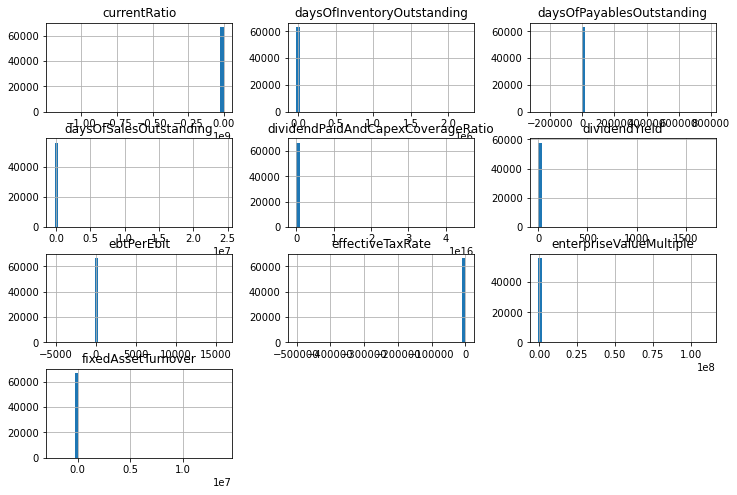

In [5]:
# Note that we find infinite values in slice [40:50]
cols = raw_df.columns
raw_df[cols[10:20]].hist(bins=50, figsize=(12,8))
plt.show()

## Data Cleaning
We first begin by dropping some columns that were used to generate the labels but are thus no longer useful. These include the columns pertaining to stock price, price of the S&P500 and any "internal" ratios of those features. There are also some features that have different names but represent the same thing, such as "cashFlowCoverageRatios" and "cashFlowToDebtRatio". These must also be taken into account and dropped.

In [6]:
redundant = ['stockPriceAverage', 'stockPriceHigh', 'stockPriceLow', 
           'stockPriceRatio_1Q', 'stockPriceRatio_2Q', 'stockPriceRatio_3Q', 
           'stockPriceRatio_4Q', 'S&P500PriceAverage', 'S&P500PriceHigh', 
           'S&P500PriceLow', 'snpPriceRatio_1Q', 'snpPriceRatio_2Q', 
           'snpPriceRatio_3Q', 'snpPriceRatio_4Q']

duplicates = ['cashFlowCoverageRatios', 'priceEarningsRatio']

to_drop = redundant + duplicates

df = raw_df.drop(to_drop, axis=1)
df.describe()

,assetTurnover,capitalExpenditureCoverageRatio,cashConversionCycle,cashFlowToDebtRatio,cashPerShare,cashRatio,companyEquityMultiplier,currentRatio,daysOfInventoryOutstanding,daysOfPayablesOutstanding,...,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital,eps,ebitdaratio,priceRatioRelativeToS&P_1Q,priceRatioRelativeToS&P_2Q,priceRatioRelativeToS&P_3Q,priceRatioRelativeToS&P_4Q
count,66627.000000,66627.000000,4.467600e+04,6.507500e+04,55966.000000,66627.000000,66627.000000,6.662700e+04,6.319700e+04,63197.000000,...,58470.000000,5.592300e+04,5.596600e+04,5.592300e+04,66627.000000,66627.000000,66009.000000,65394.000000,64788.000000,64189.000000
mean,0.018845,-6.441979,8.450875e+01,-8.514182e+01,322.532942,1.660594,10.660023,-2.257592e+04,9.831888e+01,89.433629,...,0.110049,3.141365e+11,8.561235e+02,-6.652229e+12,20.082182,-0.756832,1.003990,1.013372,1.023695,1.034927
std,52.756331,183.857490,7.846092e+03,2.215201e+04,4434.288071,134.812939,1370.541202,4.767032e+06,8.930901e+03,3868.105434,...,21.395610,4.121324e+12,3.479891e+04,1.156646e+15,380.005216,98.852987,0.155289,0.287321,0.395878,0.521533
min,-13567.842499,-18780.000000,-2.741550e+05,-5.650651e+06,-3.839224,-2.291744,-7159.071001,-1.189378e+09,-2.269636e+04,-275647.812389,...,-2001.551202,-5.224308e+11,-1.228120e+05,-2.264398e+17,-30653.000000,-14205.017232,0.106233,0.078548,0.044252,0.035015
25%,0.027859,-3.552239,1.730605e+01,0.000000e+00,0.385121,0.006443,1.415836,1.260512e-03,0.000000e+00,0.000000,...,0.000000,1.098810e+08,2.002852e+00,0.000000e+00,0.074124,0.085565,0.935053,0.895106,0.867468,0.842525
50%,0.128366,-1.140722,5.687928e+01,4.364201e-02,1.513929,0.116823,2.214035,1.213457e+00,2.166779e+01,29.702173,...,0.000000,6.212000e+08,8.209941e+00,1.693000e+08,0.310000,0.165783,0.997658,0.994573,0.991137,0.988077
75%,0.273930,0.000000,9.790742e+01,1.357583e-01,5.016452,0.382347,3.294455,2.039651e+00,6.908198e+01,54.850476,...,0.002170,3.648500e+09,1.916855e+01,9.520500e+08,0.750000,0.364413,1.063024,1.100978,1.129320,1.154034
max,794.861111,16454.666667,1.554834e+06,5.176336e+04,277352.587531,24018.891892,295234.500000,8.486500e+04,2.228760e+06,778042.346939,...,3989.627180,2.726915e+14,8.013799e+06,1.958951e+14,26377.680000,2727.025200,15.513478,35.037254,34.423041,42.343124


### Inputs and Outputs
The data will also be cut into the features (inputs) and the outputs (labels). This is because the label columns intentionally hold NaN values in specific positions. In those cases, the NaN values specifically indicate where the label could not be calculated due to time constraints on the data. We thus do not want to impute those values and we thus cut the data for this processing and then recombine at the end.

In [7]:
label_names = ['priceRatioRelativeToS&P_1Q',
             'priceRatioRelativeToS&P_2Q',
             'priceRatioRelativeToS&P_3Q',
             'priceRatioRelativeToS&P_4Q']


In [ ]:
labels_df = df[label_names].copy()
inputs_df = df.drop(label_names, axis=1).copy()

### Infinities
We will now check to find columns with infinite values in the dataset and work to address them.

In [8]:
cols_with_inf = []
for col in inputs_df:
    if np.inf in inputs_df[col].values or -np.inf in inputs_df[col].values:
        cols_with_inf.append(col)
cols_with_inf

['PE_avg', 'PE_low', 'PE_high']

We see that all the PE colums contain infinite values. Since a PE of over 50 is considered high, and that the largest stock market PE in history was around 125, we can safely set these infinite values to a large number to make the calculations feasible. 

In [9]:
replace_values = {np.inf: 10000, -np.inf:-10000}
for col in ['PE_avg', 'PE_low', 'PE_high']:
    inputs_df[col] = inputs_df[col].replace(replace_values)

# Final check for infinite values in the df
for col in inputs_df.columns:
    if np.inf in inputs_df[col].values:
        print('Found an infinite in: ', col)

We have thus cleaned infinite values from the PE columns with appropriate alternatives. 

### NaN Values

There are still however nan values that must be addressed. We now use the preprocessing_tools library to aid with the analysis. First we note that if a particular feature has a large proportion of nan values, then this will inherently be a poor feautre to learn from since a lot of the data will be falsified by imputation. We here choose thise value to be 0.5

In [10]:
inputs_df = drop_nan_columns(inputs_df, threshold=0.5)

In [11]:
cols_with_nan = check_for_nan_columns(inputs_df)

There are two "schemes" of nan values in this dataset:
- Holes in the data that can be seen as holes in a time series. In this case, it would be ideal to take a rolling average around the nan value. This should be the first approach to handling all nan values in the dataset.
    - Care must be taken not to set nan values surrounded with nan values to non-nan values!
- Long strings of nan values in the data. In this case, certain metrics with nan values intuitively can be set to zero. This is typically true for metrics such as dividendYield and payoutRatio, where an absence of a value may indicate the lack of a dividend, and thus a dividend of zero. This should be done second.
- Finally, the data can be inspected again to see what nan values are still present.

We address filling the holes first. First we add a "company" column to group the data by and then proceed with the rolling average.

In [12]:
inputs_df['company'] = inputs_df.index.to_series().apply(lambda x: x.split('-')[0])
companies = (inputs_df['company'].unique())

In [13]:
# ensuring the df is sorted and in order
inputs_df = inputs_df.sort_values(by=['company', 'date'])

# initial number of nan values
print('total nan values: ', inputs_df.isna().sum().sum())

# filling holes
for col in cols_with_nan:
    rolling_average = inputs_df.groupby('company')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean())
    inputs_df[col] = inputs_df[col].fillna(rolling_average)
    
# remaining number of nan values
print('remaining nan values: ', inputs_df.isna().sum().sum())

total nan values:  354050
remaining nan values:  315307


We see that while the method has filled some nan values, it has only addressed around 10% of them. Since the data is inherently time-series data, we now propose to fill future values with the most recent known value on a company-by-company basis. This is known as forward-filling and can be a good imputation method for time-series data. 

In [14]:
# initial number of nan values
print('total nan values: ', inputs_df.isna().sum().sum())

for col in cols_with_nan:
    inputs_df[col] = inputs_df.groupby('company')[col].apply(
    lambda x: x.ffill())
    
# remaining number of nan values
print('remaining nan values: ', inputs_df.isna().sum().sum())

total nan values:  315307
remaining nan values:  277577


We now attempt to interpolate between datapoints using linear interpolation

In [15]:
# initial number of nan values
print('total nan values: ', inputs_df.isna().sum().sum())

for col in cols_with_nan:
    inputs_df[col] = inputs_df.groupby('company')[col].apply(
    lambda x: x.interpolate(method='linear', limit_direction='both'))
    
# remaining number of nan values
print('remaining nan values: ', inputs_df.isna().sum().sum())

total nan values:  277577
remaining nan values:  15436


We see that the interpolation has largely filled in the missing values. The remaining number of nan values is very small when compared to the entire dataset. As such, a final imputation of zero is warranted. Generally, values of zero would be bad for these metrics and thus the model will in effect be penalising the companies. This imputation would thus lead to more false nagetives than false positives, which is the ideal skew in an investment situation.

In [16]:
keys_to_zero = check_for_nan_columns(inputs_df)


# initial number of nan values
print('total nan values: ', inputs_df.isna().sum().sum())

inputs_df[keys_to_zero] = inputs_df[keys_to_zero].fillna(0)

# remaining number of nan values
print('remaining nan values: ', inputs_df.isna().sum().sum())

total nan values:  15436
remaining nan values:  0


The data is thus cleaned of all infinite and nan values. We now recombine the inputs and the labels and then we will save this dataset, noting that it still includes outliers that cause the distribution to look like the histograms presented above.

In [17]:
# cleaned_df
labels_df = labels_df.sort_index()
inputs_df = inputs_df.sort_index()
cleaned_df = pd.merge(inputs_df, labels_df.loc[inputs_df.index],
                       how='outer', left_index=True, right_index=True)
cleaned_df = cleaned_df.sort_values(by=['company', 'date'])

In [18]:
cleaned_df.to_parquet('NYSE_dataset_cleaned_with_outliers.parquet')

## Data Distributions

Now the data distributions can be taken into account and outliers addressed. Looking at the data below, we see that the most agregious values occur below the 2.5th percentile and above the 97.5th percentile.

In [19]:
cleaned_df.describe(percentiles=[0, 0.025, 0.05, 0.95, 0.975, 1.0])

,assetTurnover,capitalExpenditureCoverageRatio,cashConversionCycle,cashFlowToDebtRatio,cashPerShare,cashRatio,companyEquityMultiplier,currentRatio,daysOfInventoryOutstanding,daysOfPayablesOutstanding,...,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital,eps,ebitdaratio,priceRatioRelativeToS&P_1Q,priceRatioRelativeToS&P_2Q,priceRatioRelativeToS&P_3Q,priceRatioRelativeToS&P_4Q
count,66651.000000,66651.000000,6.665100e+04,6.665100e+04,66651.000000,66651.000000,66651.000000,6.665100e+04,6.665100e+04,66651.000000,...,66651.000000,6.665100e+04,6.665100e+04,6.665100e+04,66651.000000,66651.000000,66030.000000,65409.000000,64800.000000,64198.000000
mean,0.018948,-6.440952,6.614730e+01,-8.312445e+01,286.804617,1.660101,10.656360,-2.256779e+04,9.392740e+01,85.646604,...,0.096553,3.016708e+11,7.746112e+02,-5.571125e+12,20.076445,-0.756476,1.004007,1.013397,1.023716,1.034947
std,52.746831,183.824395,6.443796e+03,2.188855e+04,4142.177243,134.788667,1370.294435,4.766174e+06,8.696438e+03,3766.633926,...,20.039557,3.901333e+12,3.191684e+04,1.059481e+15,379.936913,98.835189,0.155279,0.287301,0.395848,0.521500
min,-13567.842499,-18780.000000,-2.741550e+05,-5.650651e+06,-3.839224,-2.291744,-7159.071001,-1.189378e+09,-2.269636e+04,-275647.812389,...,-2001.551202,-5.224308e+11,-1.228120e+05,-2.264398e+17,-30653.000000,-14205.017232,0.106233,0.078548,0.044252,0.035015
0%,-13567.842499,-18780.000000,-2.741550e+05,-5.650651e+06,-3.839224,-2.291744,-7159.071001,-1.189378e+09,-2.269636e+04,-275647.812389,...,-2001.551202,-5.224308e+11,-1.228120e+05,-2.264398e+17,-30653.000000,-14205.017232,0.106233,0.078548,0.044252,0.035015
2.5%,0.000000,-31.774142,-1.995013e+02,-1.436930e-01,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,-4.684850e+09,-1.682329e+01,-1.077450e+10,-1.225698,-0.641519,0.757267,0.636287,0.557578,0.498717
5%,0.000000,-16.785527,-9.754546e+01,-5.628596e-02,0.023657,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,-1.579700e+09,-7.374726e+00,-2.486500e+09,-0.410000,-0.086676,0.814628,0.714720,0.646761,0.595307
50%,0.128441,-1.141284,4.509625e+01,4.145170e-02,1.219587,0.116875,2.213496,1.213707e+00,1.742246e+01,27.830302,...,0.000000,6.544310e+08,7.614160e+00,1.490000e+08,0.310000,0.165847,0.997681,0.994574,0.991153,0.988152
95%,0.524808,2.246562,2.226737e+02,6.659044e-01,84.557960,1.654653,10.145678,5.090742e+00,1.585911e+02,160.979361,...,0.012995,3.659200e+10,9.942543e+01,1.112350e+10,4.386764,1.000000,1.205083,1.353417,1.472062,1.576148
97.5%,0.670693,6.832230,3.615645e+02,1.703676e+00,630.924934,3.061025,14.501130,1.026115e+01,2.150287e+02,270.349624,...,0.021348,1.984370e+11,1.425612e+03,4.971190e+10,37.005000,1.000000,1.285490,1.490332,1.667510,1.826591


We cannot however drop 2.5% of our data for each feature as this will quickly reduce the size of our dataset. To address this, we create a json file that contains appropriate upper and lower bounds for each of the metrics. This was done by manually inspecting the distributions for each feature and selecting bounds that kept the majority of the data (>99%) but rejected the most agregious outliers. For each feature, instances with values outside of the appropriate bounds will be dropped.

In [20]:
with open('metric_bounds.json') as f:
    metric_bounds = json.load(f)

df_columns = cleaned_df.columns

# check to see that all df columns are represented in metric_bounds
missing_cols = [i for i in df_columns if i not in metric_bounds]
missing_cols # the only missing cols are the labels and identification columns 'date', 'period', and 'company'

['date',
 'period',
 'company',
 'priceRatioRelativeToS&P_1Q',
 'priceRatioRelativeToS&P_2Q',
 'priceRatioRelativeToS&P_3Q',
 'priceRatioRelativeToS&P_4Q']

In [21]:
print(len(cleaned_df))
dropped_df = cleaned_df.copy()
for metric, bounds in metric_bounds.items():
    lower, upper = bounds[0], bounds[1]
    dropped_df = dropped_df[(dropped_df[metric] >= lower) & (dropped_df[metric] <= upper)]
print(len(dropped_df))

66651
20958


It turns out that dropping even a relatively small number of instances based on the input features results in a large reduction in the size of the dataset. This makes sense since there are around 95 input features. This is however not desirable and must be avoided. We thus delete the newly created dropped_df and begin again by copying the cleaned_df, which contains all features and instances but with clean data.

In [22]:
del dropped_df

Up until now the goal was to keep as many of the features as possible in order to preserve as many relationships as possible. But it is now time to select features that will move forward into the training process. We will drop features that have the following characeristics:
- Features that are contain raw dollar amounts as opposed to financial metrics. These would inherently skew the data since company size varies dramatically.
- Features that are related to each other, such as payoutRatio and dividendPaidAndCapexCoverateRatio.
- Features that are highly correlated with other features, such as PE_high, PE_low and PE_avg.
- Features that are mostly (>50%) zero. 

When doing the dropping, the initial primary focus will be to keep the "standard" financial metrics that commonly occur in fundamental analysis, such as eps, ROE, ROA, payoutRatio, etc, and to neglect less common metrics such as the companyEquityMultiplier.

In [65]:
raw_dollar_features = ["averageInventory",
                        "averagePayables",
                        "averageReceivables",
                        "enterpriseValue",
                        "netCurrentAssetValue",
                        "tangibleAssetValue",
                        "workingCapital",
                        "investedCapital"
]

duplicate_features = [
    'companyEquityMultiplier', # similar to debtToAssets
    'capitalExpenditureCoverageRatio', # captured in dividendPaidAndCapexCoverageRatio 
    'operatingCycle', # captured in cashConversionCycle
    'ebtPerEbit', # captured in netIncomePerEbt
    'priceToFreeCashFlowsRatio', # captured in evToFreeCashFlow
    'priceToOperatingCashFlowsRatio', #captured in evToOperatingCashFlow
    'PE_low', # PE_avg
    'PE_high', #PE_avg
    'daysSalesOutstanding', #captured in daysOfSalesOutstanding
    'priceToSalesRatio', # captured in evToSales
    'netIncomePerShare', #captured in eps
    'tangibleBookValuePerShare', # captured in bookValuePerShare
    'returnOnTangibleAssets', # captured in returnOnAssets
    'netDebtToEBITDA', #captured in debtToEquity and totalDebtToCapitalization

]

to_drop = raw_dollar_features + duplicate_features
dropped_df = cleaned_df.drop(to_drop, axis=1)

We now create a new json file containing metric bounds called "metric_bounds_expanded.json" with expanded bounds to ensure that we are dropping as few instances as possible.

In [68]:
with open('metric_bounds_expanded.json') as f:
    metric_bounds_expanded = json.load(f)
    
print(len(dropped_df))
for metric, bounds in metric_bounds_expanded.items():
    if metric in dropped_df.columns:
        lower, upper = bounds[0], bounds[1]
        dropped_df = dropped_df[(dropped_df[metric] >= lower) & (dropped_df[metric] <= upper)]
print(len(dropped_df))

66651
49889


We now see that our dataset still contains around 50k instances, which should be more than enough to cover basic ML models. If the performance of the models is poor then we can consider coming back and revisiting this data cleaning process.

**It should be noted that we have dropped outliers from the dataset. It could be that these outliers were in fact the high performing companies that we were seeking.** 

We see below however that at least half the data points outperformed the market, so a simple binary classification should be feasible with this data. We expect the number of instances with larger price gains to become more rare as the relative price gain inscreases.

Note also the time horizon. Selecting a relative price ratio of 2 for the 'priceRatioRelativeToS&P_1Q' is much mor bullish than for the 'priceRatioRelativeToS&P_4Q'.

In [86]:
sum(dropped_df['priceRatioRelativeToS&P_1Q'] > 1)

24413

In [87]:
sum(dropped_df['priceRatioRelativeToS&P_1Q'] > 2)

38

In [92]:
sum(dropped_df['priceRatioRelativeToS&P_4Q'] > 2)

764

We now save this working dataset and begin moving into some machine learning modelling.

In [89]:
dropped_df.to_parquet('NYSE_dataset_v1.parquet')

## Linear Regression Datasets
When preparing the above data for linear regression it became clear that the dataset was in no state for use in ML models. In particular it was observed that the majority of the features had weak correlations with the output, less that 0.03 in most cases. As such the data will be prepared by hand-selecting the features with the strongest correlations with the outputs and then rejecting outliers of only those features. This will make the dataset much more managable for this simple project and will allow us to retain as much data as possible while ensuring that the distributions are appropriate.

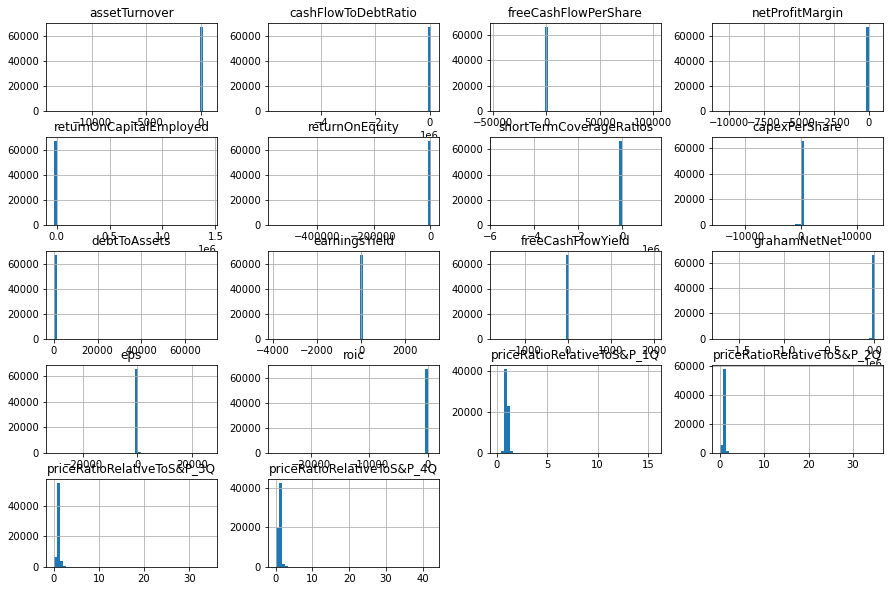

In [98]:
df = pd.read_parquet('NYSE_dataset_cleaned_with_outliers.parquet')
to_keep = [
    'assetTurnover',
    'cashFlowToDebtRatio',
    'freeCashFlowPerShare',
    'netProfitMargin',
    'returnOnCapitalEmployed',
    'returnOnEquity',
    'shortTermCoverageRatios',
    'capexPerShare',
    'debtToAssets',
    'earningsYield',
    'freeCashFlowYield',
    'grahamNetNet',
    'eps',
    'roic',
    'priceRatioRelativeToS&P_1Q',
    'priceRatioRelativeToS&P_2Q',
    'priceRatioRelativeToS&P_3Q',
    'priceRatioRelativeToS&P_4Q'
    
]
df = df[to_keep]
df.hist(bins=50, figsize=(15,10))
plt.show()

In [99]:
with open('metric_bounds.json') as f:
    metric_bounds = json.load(f)
    
print(len(df))
for metric, bounds in metric_bounds.items():
    if metric in df.columns:
        lower, upper = bounds[0], bounds[1]
        df = df[(df[metric] >= lower) & (df[metric] <= upper)]
print(len(df))

66651
37283


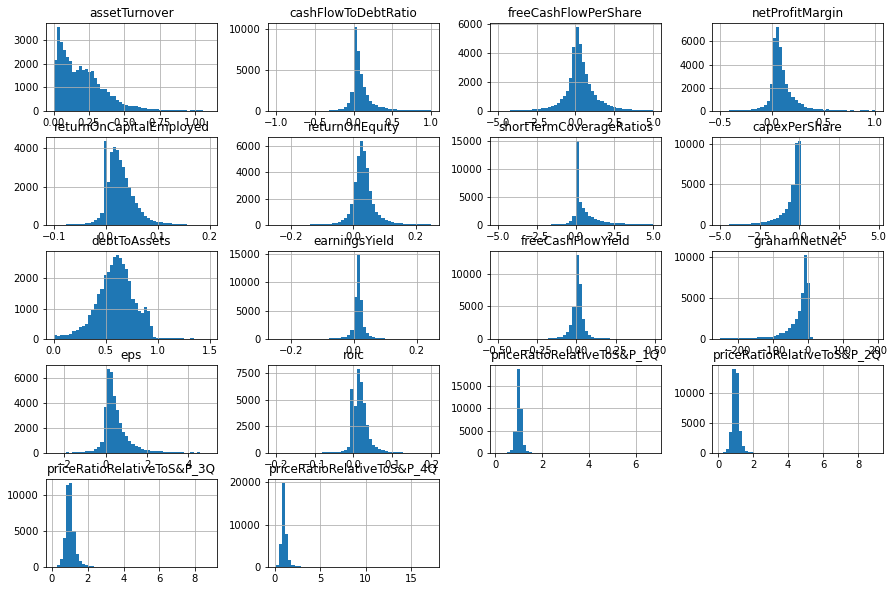

In [100]:
df.hist(bins=50, figsize=(15,10))
plt.show()
# Distributions looking much better and we retain 40k instances

In [101]:
# further adjustments on some of the distributions
df.capexPerShare = df.capexPerShare.apply(lambda x: -x)
df = df[df.capexPerShare > 0]
df.capexPerShare = df.capexPerShare.apply(lambda x: math.log(x))

df.grahamNetNet = df.grahamNetNet.apply(lambda x: -x)
df = df[df.grahamNetNet > 0]
df.grahamNetNet = df.grahamNetNet.apply(lambda x: math.log(x))

df.assetTurnover = df.assetTurnover.apply(lambda x: math.log(x))

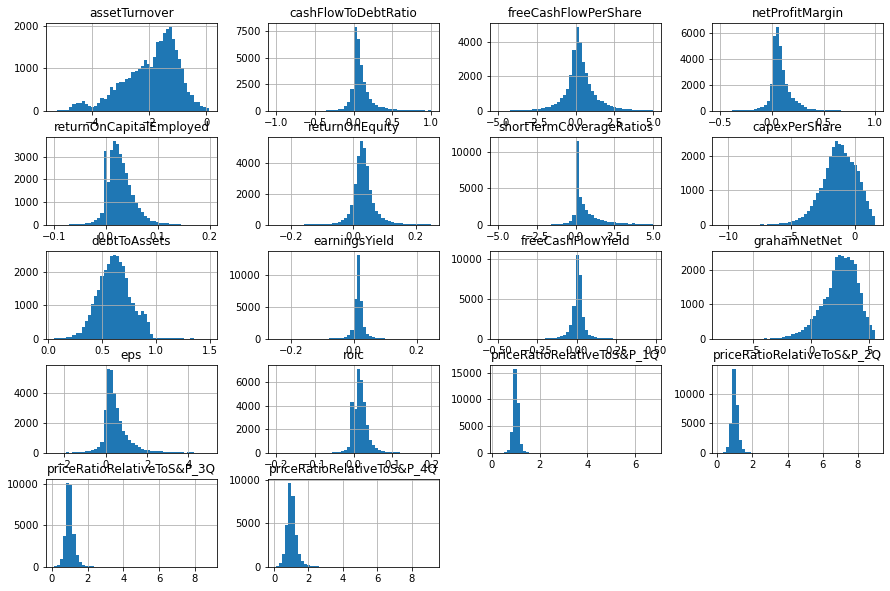

In [102]:
df.hist(bins=50, figsize=(15,10))
plt.show()

In [103]:
# dropping shortTermCoverageRatios as it still has a poor distribution.
df = df.drop(['shortTermCoverageRatios'], axis=1)

In [104]:
df.to_parquet('NYSE_dataset_v2_linregress.parquet')